In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import paper_cka
import transformers
from datasets import load_dataset

transformers.logging.set_verbosity_error()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


In [2]:
import inspect, re


def varname(p) -> str:
    for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
        m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
        if m:
            return str(m.group(1))

In [3]:
import gc


class ClearCache:

    def __enter__(self):
        gc.collect()
        torch.cuda.empty_cache()

    def __exit__(self, exc_type, exc_val, exc_tb):
        gc.collect()
        torch.cuda.empty_cache()

In [4]:
from typing import List, Dict, Any

PREFIX_TASK = {'en': "English", 'fr': "French", 'de': "German", 'es': "Spanish"}


def tokenize(examples: List[Dict[str, str]], **kwargs):
    tokenizer = kwargs['tokenizer']
    src_lang: str = kwargs['lang1']
    tgt_lang: str = kwargs['lang2']
    if "task" in kwargs:
        task: str = kwargs['task']
        batch_src: List[str] = [task + e[src_lang] for e in examples]
    else:
        batch_src: List[str] = [e[src_lang] for e in examples]
    batch_tgt: List[str] = [e[tgt_lang] for e in examples]
    # tokenize the batch of sentences
    outputs = tokenizer(batch_src, text_target=batch_tgt, return_special_tokens_mask=False,
                        add_special_tokens=True, truncation=True,
                        max_length=128, padding='max_length',
                        return_attention_mask=False, return_tensors='pt')
    # labels = tokenizer(batch_tgt, truncation=False)
    # batch_tgt = tokenizer.batch_decode(labels['input_ids'], skip_special_tokens=True)

    return {'input_ids': outputs['input_ids'], 'labels': outputs['labels']}

In [5]:
from torch.utils.data import DataLoader
from datasets import Dataset


def create_dataloader(trans_pair_ds: Dataset, input_column: str, fn_kwargs: Dict[str, Any],
                      batch_size: int) -> DataLoader:
    trans_pair_ds = trans_pair_ds.map(tokenize, batched=True, input_columns=[input_column],
                                      fn_kwargs=fn_kwargs)
    # trans_pair_ds = trans_pair_ds.remove_columns(column_names=['translation', 'original_text'])
    trans_pair_ds = trans_pair_ds.with_format('torch', columns=["input_ids", "labels"], output_all_columns=False)

    # ids = [e['input_ids'].view(1, -1) for e in iter(trans_pair_ds)]
    test_loader = DataLoader(trans_pair_ds, num_workers=2, batch_size=batch_size, drop_last=True, pin_memory=False)
    return test_loader


In [6]:
def get_comparison_set(src_lang: str, tgt_lang: str, tok_model: str, split: str = "validation[0:128]",
                       batch_size: int = 8, use_prefix_task: bool = False):
    fn_kwargs = {'lang1': src_lang, 'lang2': tgt_lang}

    lang_2 = fn_kwargs['lang1'] if fn_kwargs['lang1'] != "en" else fn_kwargs['lang2']
    val_set_name = "nikodallanoce/wmt14" if src_lang == "es" or tgt_lang == "es" else "wmt14"
    wmt14_val = load_dataset(val_set_name, f"{lang_2}-en",
                             cache_dir="/data/n.dallanoce/wmt14",
                             split=split,
                             verification_mode='no_checks')
    tok = None
    if tok_model == "mbart":
        src_mbart = fn_kwargs['lang1'] + "_XX" if fn_kwargs['lang1'] != "de" else fn_kwargs['lang1'] + "_DE"
        tgt_mbart = fn_kwargs['lang2'] + "_XX" if fn_kwargs['lang2'] != "de" else fn_kwargs['lang2'] + "_DE"
        print([src_mbart, tgt_mbart])
        tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang=src_mbart,
                                            tgt_lang=tgt_mbart)
    elif tok_model == "mt6":
        tok = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
    assert tok is not None
    fn_kwargs['tokenizer'] = tok

    if use_prefix_task and tok_model == "mt6":
        fn_kwargs['task'] = f"translate {PREFIX_TASK[src_lang]} to {PREFIX_TASK[tgt_lang]}: "

    return create_dataloader(wmt14_val, "translation", fn_kwargs, batch_size)

# mBART

In [7]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir), output_attentions=True)
step_ft_models = list(list_models.values())

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


In [8]:
from transformers import MBartConfig

mbart_tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=mbart_tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)

only_ft_en_fr: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_ft_only/checkpoint-100000",
    output_attentions=True)

last_ft_model = list(list_models.values())[-1]

# m1_model = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
# m2_model = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)/checkpoint-180000", output_attentions=True)
# m2_model_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)_replay_8/checkpoint-180000",
#     output_attentions=True)
# m3_model = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)/checkpoint-180000",
#     output_attentions=True)
# m3_model_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)_replay_8/checkpoint-180000",
#     output_attentions=True)
# de_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_en-de/checkpoint-180000", output_attentions=True)
# 
# mf1_2_rply_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)_replay_8/checkpoint-90000",
#     output_attentions=True)
# 
# mf12_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)/checkpoint-100000",
#     output_attentions=True)
# 
# mf1_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/checkpoint-100000",
#     output_attentions=True)
# 
# mf2_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de-Mf2/checkpoint-100000",
#     output_attentions=True)
# 
# mf2_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de-Mf2_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# mf23_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-de(Mf2-3)/checkpoint-80000",
#     output_attentions=True)
# mf23_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-de(Mf2-3)_replay_8/checkpoint-95000",
#     output_attentions=True)
# mf13_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-fr(Mf3-1)/checkpoint-85000",
#     output_attentions=True)
# mf13_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_es_ft_en-fr(Mf3-1)_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# only_ft_en_de: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de_ft_only/checkpoint-100000",
#     output_attentions=True)
# 
# mf3_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-es/checkpoint-100000",
#     output_attentions=True)
# 
# mf3_model_rply: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-es_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# col_names = ['(m1, m2)', '(m2, m3)', '(m1, m3)', '(m2, de)', '(m2, rnd)']

In [9]:
# mbart_str2model = {
#     "M1": m1_model,
#     "M2": m2_model,
#     "M2_replay": m2_model_rply,
#     "M3": m3_model,
#     "M3_replay": m3_model_rply,
#     "MF1": mf1_model,
#     "MF1-2": mf12_model,
#     #"MF1-2_replay":mf12_model_rply,
#     "MF2": mf2_model,
#     "MF2_replay": mf2_model_rply,
#     "MF3": mf3_model,
#     "MF3_replay": mf3_model_rply,
#     "MF2-3": mf23_model,
#     "MF2-3_replay": mf23_model_rply,
#     "MF1-3": mf13_model,
#     "MF1-3_replay": mf13_model_rply
# }
from utilities.models import get_all_mbart_models

mbart_str2model = get_all_mbart_models()

In [10]:
get_comparison_set("de", "en", "mbart")

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


['de_DE', 'en_XX']


Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-3bf972aa91f883c8.arrow


In [11]:
layers_enc_norm = [f"model.encoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [
    f"model.encoder.layers.{i}.final_layer_norm" for i in range(6)]
layers_enc_fc = [f"model.encoder.layers.{i}.fc1" for i in range(6)] + [f"model.encoder.layers.{i}.fc2" for i in
                                                                       range(6)]
layers_dec_fc = [f"model.decoder.layers.{i}.fc1" for i in range(6)] + [f"model.decoder.layers.{i}.fc2" for i in
                                                                       range(6)]
layers_dec_norm = [f"model.decoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [
    f"model.decoder.layers.{i}.final_layer_norm" for i in range(6)] + [
                      f"model.decoder.layers.{i}.encoder_attn_layer_norm" for i in range(6)]
#layers_enc_dec_norm = [f"model.decoder.layers.{i}.encoder_attn_layer_norm" for i in range(6)]

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


['en_XX', 'fr_XX']


Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-6e4147578e74ab69.arrow
| Comparing features |: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


0.957


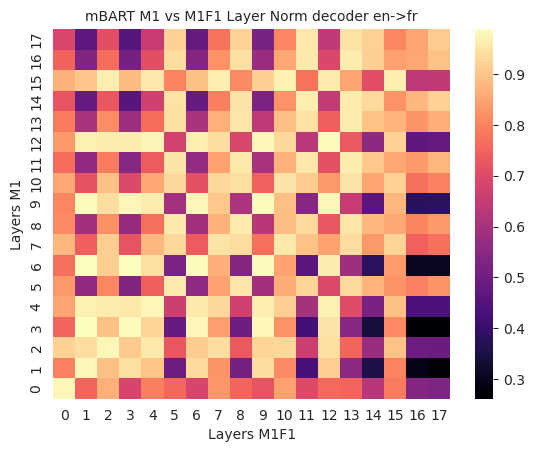

| Comparing features |: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


0.878


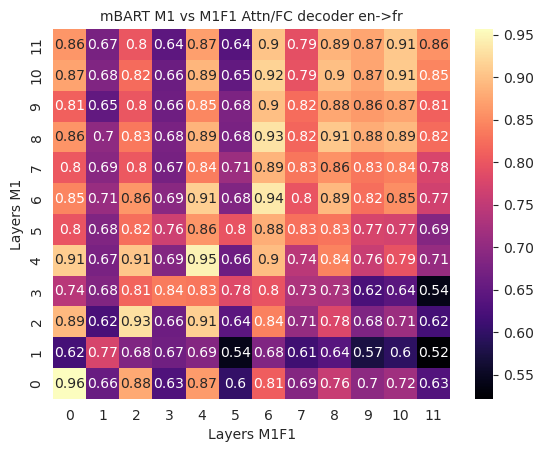

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


['fr_XX', 'en_XX']


Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-11ee1ece2cbb51cd.arrow
| Comparing features |: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


0.948


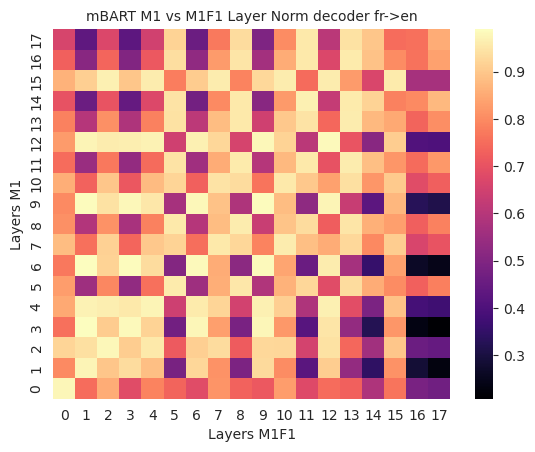

| Comparing features |: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


0.875


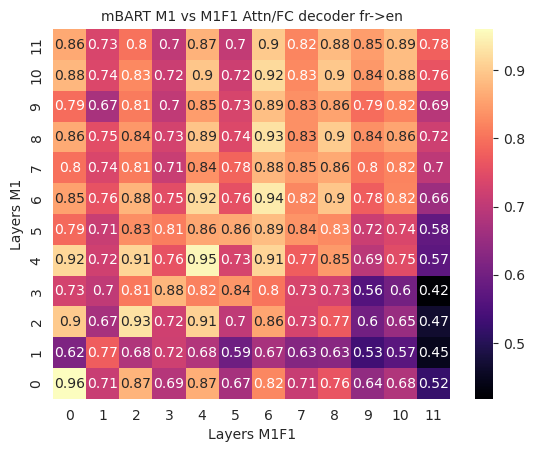

In [13]:
#layers = [f"model.encoder.layers.{i}.self_attn.out_proj" for i in range(6)]
#src_lang, tgt_lang = "en", "es"

type_of_comp_enc = {0: "Layer Norm", 1: "Attn/FC"}
lang_pairs = [("en", "fr"), ("fr", "en")]
for pair in lang_pairs:
    src_lang, tgt_lang = pair
    dataloader_val = get_comparison_set(src_lang, tgt_lang, "mbart")
    for i, l_t in enumerate([layers_dec_norm, layers_dec_fc]):
        with ClearCache():
            with torch.no_grad():
                name1 = "M1"
                name2 = "M1F1"
                cka = paper_cka.CKA(mbart_str2model[name1], mbart_str2model[name2], name1, name2, model1_layers=l_t,
                                    model2_layers=l_t, device="cuda:0")
                sim = cka.compare(dataloader_val, debiased=True)
                print(round(sim, 3))
                #print(cka.sanity_check())
                cka.plot_results(show_ticks_labels=False,
                                 title=f"mBART {name1} vs {name2} {type_of_comp_enc[i]} decoder {src_lang}->{tgt_lang}",
                                 save_path="cka_imgs/mbart/decoder/thesis", show_annotations=len(l_t) <= 12)
#
#print(cka.model1_info['Layers'])
#print(cka.export()["CKA"])
#print(m1_model)

In [ ]:
lang_pairs = [("en", "fr"), ("en", "de"), ("en", "es"), ("fr", "en"), ("de", "en"), ("es", "en")]
type_of_comp_enc = {0: "Layer Norm", 1: "Attn/FC"}
layer_to_comp = {"encoder": [layers_enc_norm, layers_enc_fc],
                 "decoder": [layers_dec_norm, layers_dec_fc]}

for pair in lang_pairs:
    src_lang, tgt_lang = pair
    dataloader_val = get_comparison_set(src_lang, tgt_lang, "mbart")
    for model1_name, model1 in mbart_str2model.items():
        for model2_name, model2 in mbart_str2model.items():
            if model1_name == model2_name:
                continue
            for block_name, layers in layer_to_comp.items():
                l1, l2 = layers
                for i, l_t in enumerate(layers):
                    with ClearCache():
                        with torch.no_grad():
                            print(
                                f"Comparing {model1_name} vs {model2_name} {type_of_comp_enc[i]} {block_name} {src_lang}->{tgt_lang}")
                            cka = paper_cka.CKA(model1, model2, model1_name, model2_name,
                                                model1_layers=l_t,
                                                model2_layers=l_t, device="cuda:0")
                            cka.compare(dataloader_val, debiased=True)
                            cka.plot_results(show_ticks_labels=True, short_tick_labels_splits=2,
                                             title=f"mBART {model1_name} vs {model2_name} {type_of_comp_enc[i]} {block_name} {src_lang}->{tgt_lang}",
                                             save_path=f"cka_imgs/mbart/{block_name}", show_annotations=len(l_t) <= 12,
                                             show_img=True)

In [ ]:
m1_model = mbart_str2model["M1"]
all_lyrs = list(m1_model.named_modules())
all_lyrs

In [ ]:
m1_model.model.encoder.layers[0]

# mT6

In [7]:
from transformers import MT5Config
from MT6 import MT6

# mt6_m1 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr(M1)_10_10_20_tb/checkpoint-180000",
#     output_attentions=True)
# 
# mt6_m2 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb/checkpoint-180000",
#     output_attentions=True)
# mt6_m2_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de(M2)_10_20_tb_replay_8/checkpoint-180000",
#     output_attentions=True)
# mt6_m3 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de_es(M3)_10_20_tb/checkpoint-180000",
#     output_attentions=True)
# mt6_m3_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_en-fr_de_es(M3)_10_20_tb_replay_8/checkpoint-180000",
#     output_attentions=True)
# 
# mt6_mf1_2_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_de_ft_en-fr(MF1-2)_10_20_tb_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf1_2 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_de_ft_en-fr(MF1-2)_10_20_tb/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf1 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-fr(MF1)_10_10_20_s_tb/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf2 = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-de(MF2)_10_20_tb/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf2_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-de(MF2)_10_20_tb_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# mf23_model: AutoModelForSeq2SeqLM = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-de(MF2-3)_10_10_tb/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf23_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-de(MF2-3)_10_20_tb_replay_8/checkpoint-100000",
#     output_attentions=True)
# mt6_mf13: AutoModelForSeq2SeqLM = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-fr-MF3-1_10_20_tb/checkpoint-100000",
#     output_attentions=True)
# mt6_mf13_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_pre_es_ft_en-fr-MF3-1_10_20_tb_replay_8/checkpoint-100000",
#     output_attentions=True)
# 
# # only_ft_en_de: AutoModelForSeq2SeqLM = AutoModelForSeq2SeqLM.from_pretrained(
# #     "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-de_ft_only/checkpoint-100000",
# #     output_attentions=True)
# 
# mt6_mf3: AutoModelForSeq2SeqLM = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-es/checkpoint-100000",
#     output_attentions=True)
# 
# mt6_mf3_rply = AutoModelForSeq2SeqLM.from_pretrained(
#     "/home/n.dallanoce/PyCharm/pretraining/weights/mt6_ft_en-es(MF3)_10_20_tb_replay_8/checkpoint-100000",
#     output_attentions=True)
mt6_tok = AutoTokenizer.from_pretrained("nikodallanoce/mt5-cc4-vanilla-32k-5")
mt6_rnd = MT5ForConditionalGeneration(
    MT5Config(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=len(mt6_tok), max_length=128,
              tie_word_embeddings=True))

In [8]:
# mt6_str2model = {
#     "rnd": mt6_rnd,
#     "M1": mt6_m1,
#     "M2": mt6_m2,
#     "M2_replay": mt6_m2_rply,
#     "M3": mt6_m3,
#     "M3_replay": mt6_m3_rply,
#     "MF1": mt6_mf1,
#     "MF1-2": mt6_mf1_2,
#     "MF1-2_replay": mt6_mf1_2_rply,
#     "MF2": mt6_mf2,
#     "MF2_replay": mt6_mf2_rply,
#     "MF3": mt6_mf3,
#     "MF3_replay": mt6_mf3_rply,
#     #"MF2-3": mt6mf,
#     "MF2-3_replay": mt6_mf23_rply,
#     "MF1-3": mt6_mf13,
#     "MF1-3_replay": mt6_mf13_rply
# }
from utilities.models import get_all_mt6_models
mt6_str2model = get_all_mt6_models()

In [9]:
mt6_m1 = mt6_str2model['M1']
mt6_m1.decoder.block[0]

MT5Block(
  (layer): ModuleList(
    (0): MT5LayerSelfAttention(
      (SelfAttention): MT5Attention(
        (q): Linear(in_features=512, out_features=512, bias=False)
        (k): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
        (o): Linear(in_features=512, out_features=512, bias=False)
        (relative_attention_bias): Embedding(32, 8)
      )
      (layer_norm): MT5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): MT5LayerCrossAttention(
      (EncDecAttention): MT5Attention(
        (q): Linear(in_features=512, out_features=512, bias=False)
        (k): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
        (o): Linear(in_features=512, out_features=512, bias=False)
      )
      (layer_norm): MT5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): MT5LayerFF(
      (DenseReluDense): M

In [10]:
all_lyrs = list(mt6_m1.named_modules())
all_lyrs

[('',
  MT5ForConditionalGeneration(
    (shared): Embedding(32103, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(32103, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=2048, bias=False)
                (wi_1): Linear(in_feature

In [9]:
num_layers = 6
layers_norm_enc_mt6 = [f"encoder.block.{i}.layer.0.layer_norm" for i in range(num_layers)] + [
    f"encoder.block.{i}.layer.1.layer_norm" for i in range(num_layers)]
layers_fc_enc_mt6 = [f"encoder.block.{i}.layer.1.DenseReluDense.wi_0" for i in range(num_layers)] + [
    f"encoder.block.{i}.layer.1.DenseReluDense.wo" for i in
    range(num_layers)]  #+ [f"encoder.block.{i}.layer.1.DenseReluDense.wi_1" for i in range(num_layers)]
layers_norm_dec_mt6 = [f"decoder.block.{i}.layer.0.layer_norm" for i in range(num_layers)] + [
    f"decoder.block.{i}.layer.1.layer_norm" for i in range(num_layers)] + [f"decoder.block.{i}.layer.2.layer_norm" for i
                                                                           in range(num_layers)]
layers_fc_dec_mt6 = [f"decoder.block.{i}.layer.2.DenseReluDense.wi_0" for i in range(num_layers)] + [
    f"decoder.block.{i}.layer.2.DenseReluDense.wo" for i in range(num_layers)]

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-9716ae07c99d130c.arrow
| Comparing features |: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


0.927


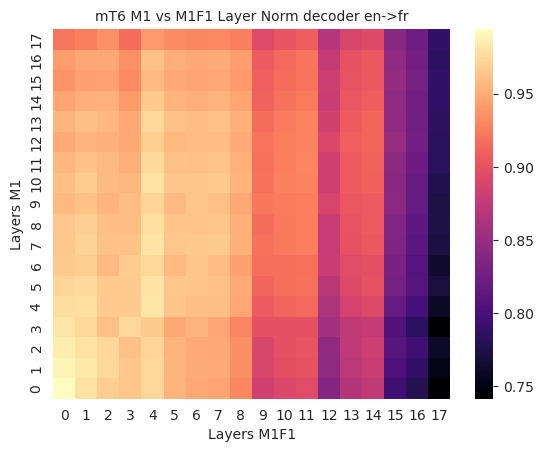

| Comparing features |: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


0.803


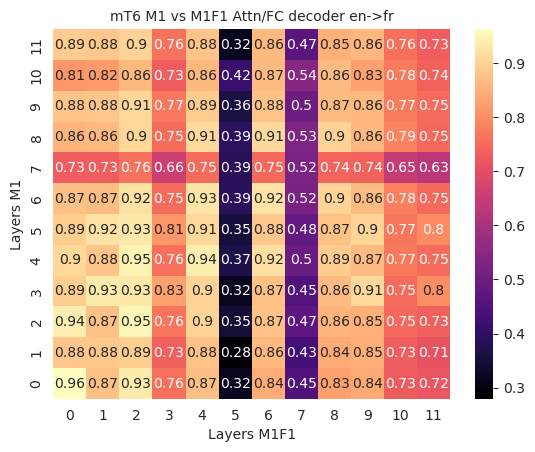

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-dd9660822d9c51ca.arrow
| Comparing features |: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


0.906


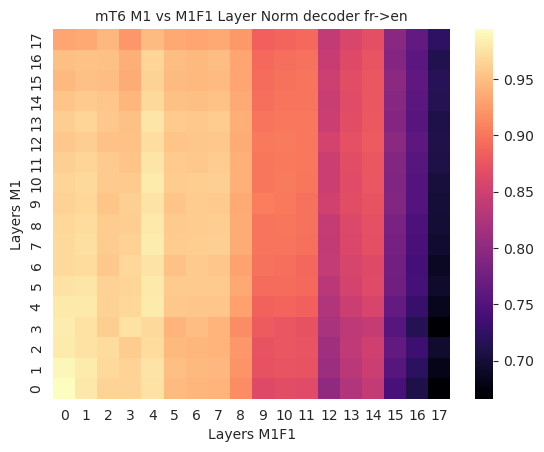

| Comparing features |: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


0.791


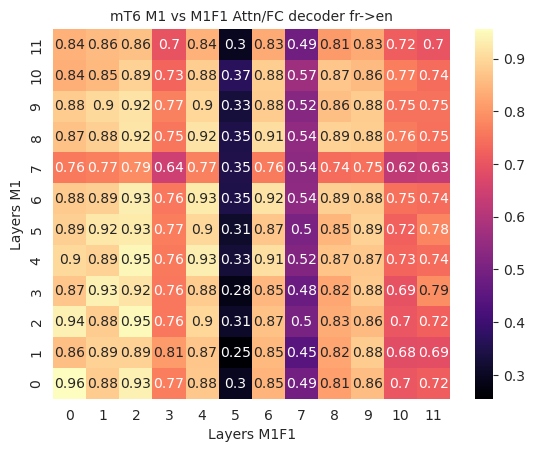

In [13]:
lang_pairs = [("en", "fr"), ("fr", "en")]
type_of_comp_enc = {0: "Layer Norm", 1: "Attn/FC"}
block_name = "decoder"
for pair in lang_pairs:
    src_lang, tgt_lang = pair
    dataloader_val = get_comparison_set(src_lang, tgt_lang, "mt6", use_prefix_task=False)
    for i, l_t in enumerate([layers_norm_dec_mt6, layers_fc_dec_mt6]):
        with ClearCache():
            with torch.no_grad():
                name1 = "M1"
                name2 = "M1F1"
                cka = paper_cka.CKA(mt6_str2model[name1], mt6_str2model[name2], name1, name2, model1_layers=l_t,
                                    model2_layers=l_t,
                                    device="cuda:0")
                cs = cka.compare(dataloader_val, debiased=True)
                print(round(cs, 3))
                #print(cka.sanity_check())
                cka.plot_results(show_ticks_labels=False, short_tick_labels_splits=4,
                                 title=f"mT6 {name1} vs {name2} {type_of_comp_enc[i]} {block_name} {src_lang}->{tgt_lang}",
                                 save_path=f"cka_imgs/mt6/{block_name}/thesis", show_annotations=len(l_t) <= 12)
            